# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Основные шаги:
1. Загрузите данные, путь к файлу: /datasets/autos.csv.
2. Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
3. Подготовьте выборки для обучения моделей.
4. Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
5. Проанализируйте время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

Примечания:
- Для оценки качества моделей применяйте метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del.

Описание данных.
Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
Целевой признак:
- Price — цена (евро)

## Подготовка данных

In [1]:
!pip install catboost -U
!pip install lightgbm -U


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from random import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import matplotlib.pyplot as plt
import time
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('D:/Yandex/autos.csv')

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.tail()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
data.duplicated().sum()

4

In [8]:
data = data.drop_duplicates()

In [9]:
data.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [10]:
# Удалим 6 неинформативных для модели признаков
data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [11]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


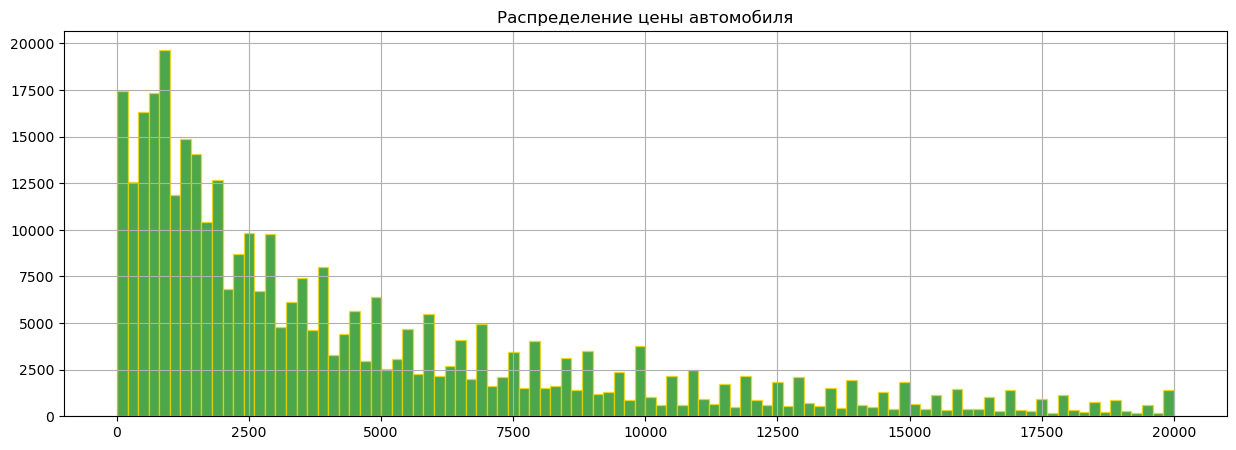

In [12]:
# Цена автомобиля
data['Price'].hist(figsize=(15, 5), bins=100, alpha=0.7, color='green', edgecolor = 'gold')
plt.grid(True)
plt.title('Распределение цены автомобиля')
plt.show()

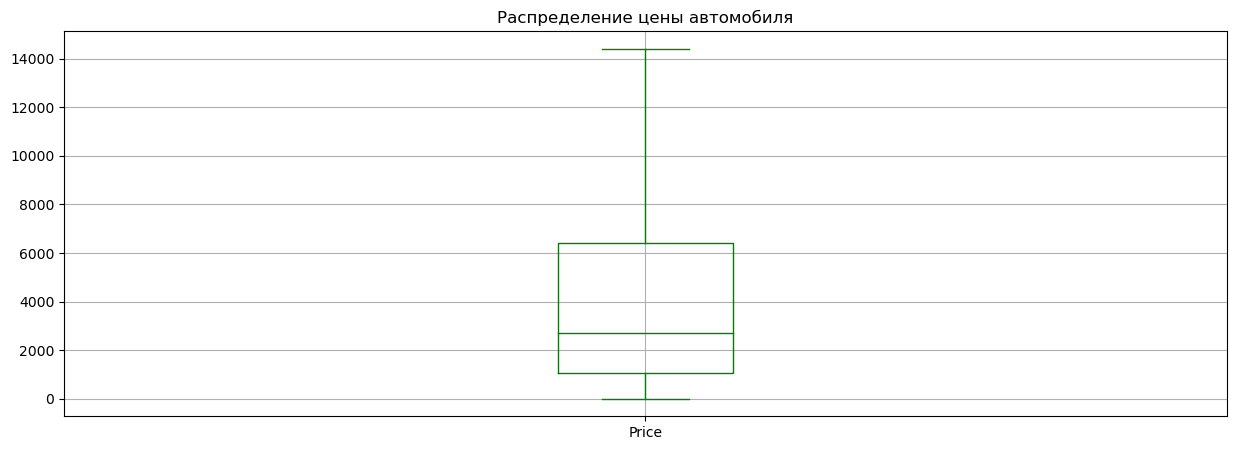

In [13]:
# Цена автомобиля
data.boxplot(column='Price', showfliers=False, figsize=(15, 5), color='green')
plt.title('Распределение цены автомобиля')
plt.show()

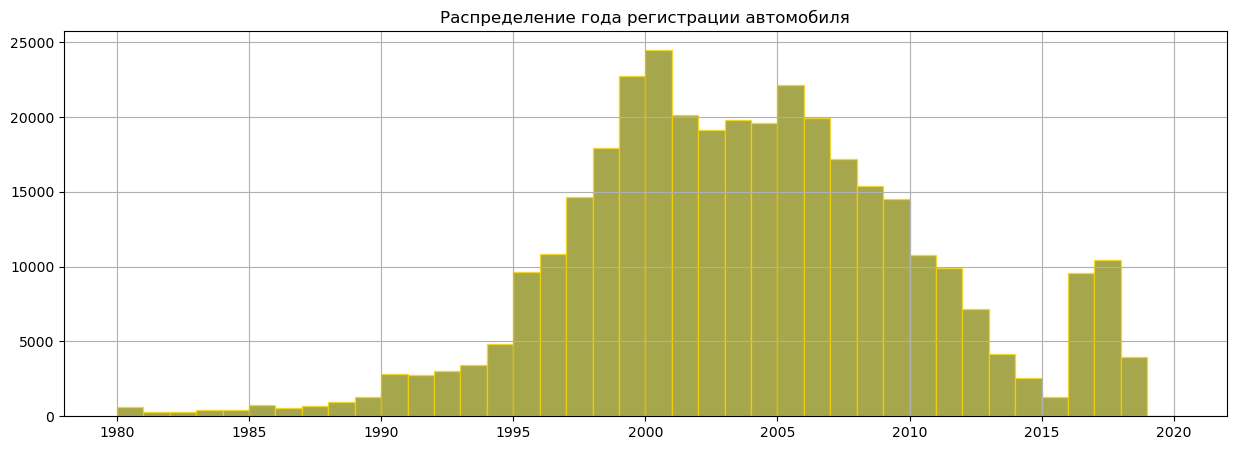

In [14]:
# Год регистрации автомобиля
data['RegistrationYear'].hist(figsize=(15, 5), range=(1980, 2020), bins=40, alpha=0.7, color='olive', edgecolor = 'gold')
plt.grid(True)
plt.title('Распределение года регистрации автомобиля')
plt.show()

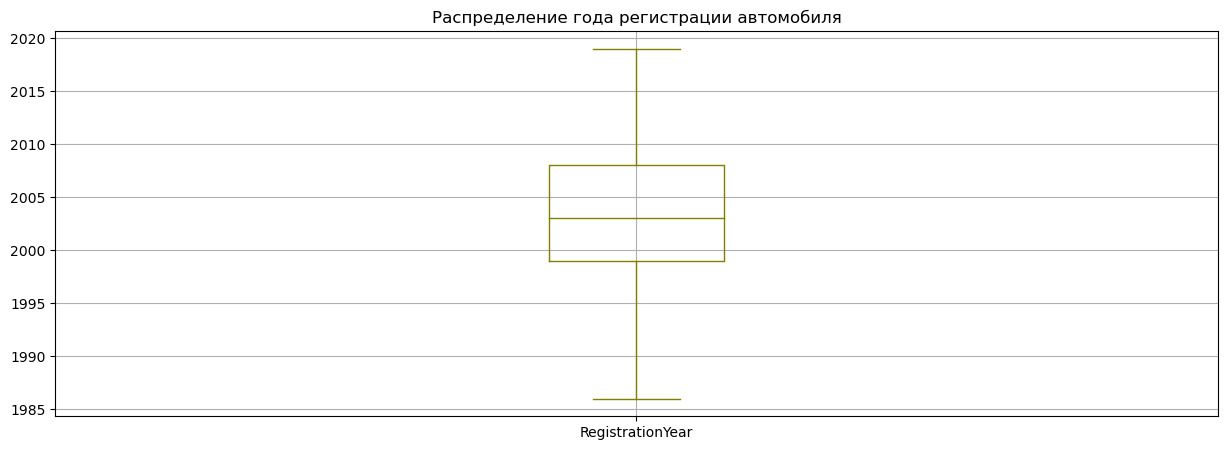

In [15]:
# Год регистрации автомобиля
data.boxplot(column='RegistrationYear', showfliers=False, figsize=(15, 5), color='olive')
plt.title('Распределение года регистрации автомобиля')
plt.show()

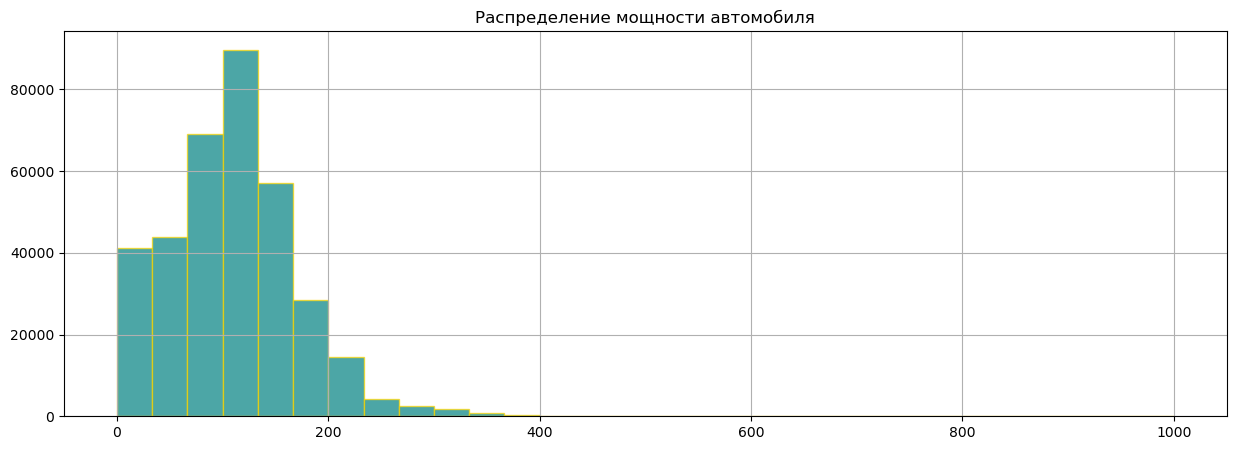

In [16]:
# Мощность автомобиля
data['Power'].hist(figsize=(15, 5), range=(0, 1000), bins=30, alpha=0.7, color='teal', edgecolor = 'gold')
plt.grid(True)
plt.title('Распределение мощности автомобиля')
plt.show()

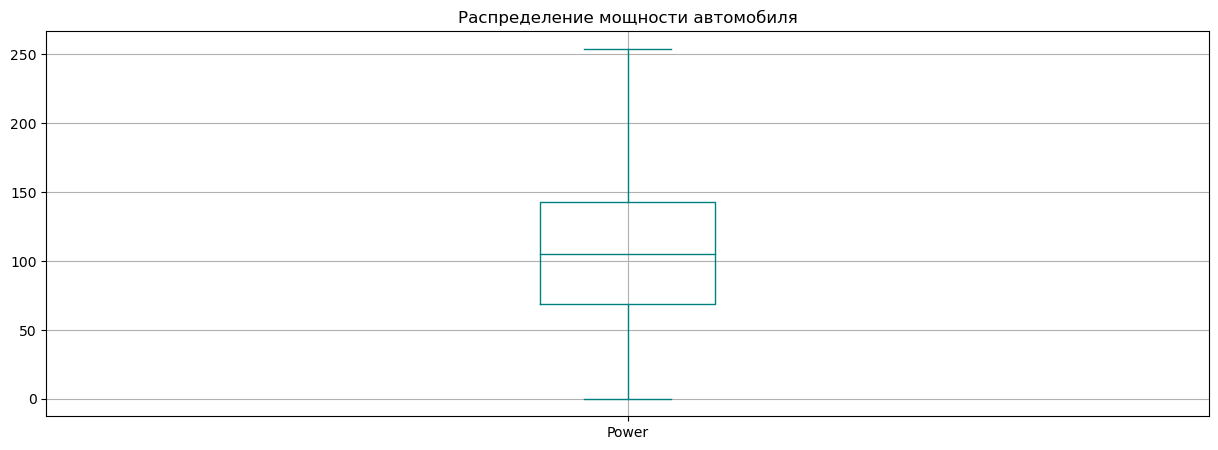

In [17]:
# Мощность автомобиля
data.boxplot(column='Power', showfliers=False, figsize=(15, 5), color='teal')
plt.title('Распределение мощности автомобиля')
plt.show()

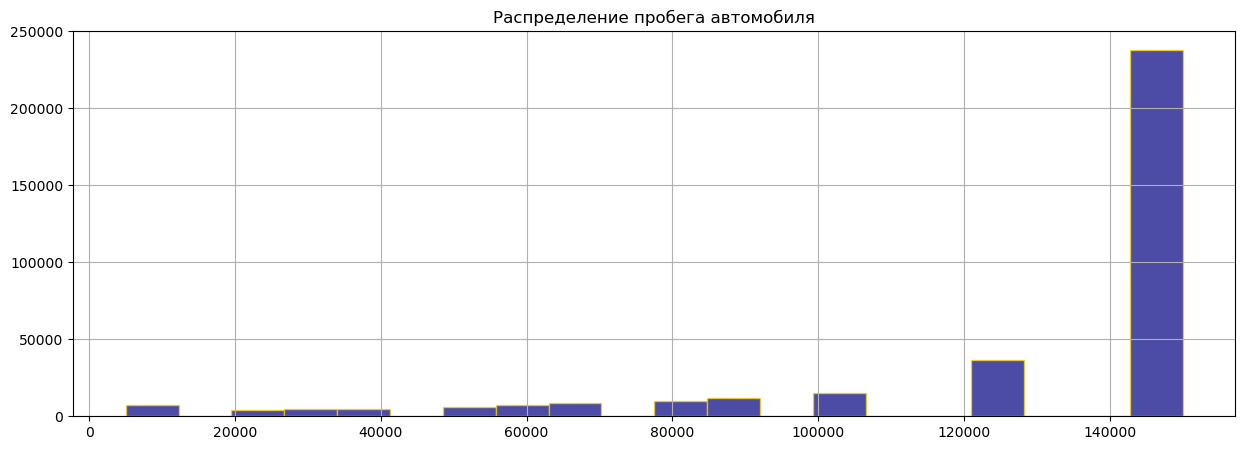

In [18]:
# Пробег автомобиля
data['Kilometer'].hist(figsize=(15, 5), bins=20, alpha=0.7, color='navy', edgecolor = 'gold')
plt.grid(True)
plt.title('Распределение пробега автомобиля')
plt.show()

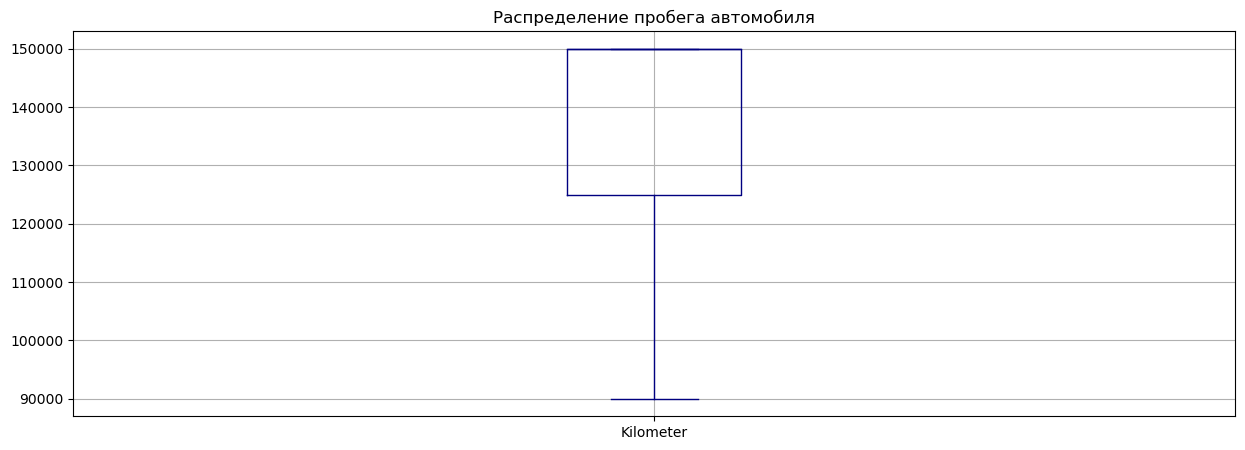

In [19]:
# Пробег автомобиля
data.boxplot(column='Kilometer', showfliers=False, figsize=(15, 5), color='navy')
plt.title('Распределение пробега автомобиля')
plt.show()

In [20]:
print(len(data['RegistrationYear'].unique()))
print(len(data['Model'].unique()))
print(len(data['Brand'].unique()))

151
251
40


In [21]:
data = data[(data['RegistrationYear'] >= 1985) & (data['RegistrationYear'] <= 2016)]
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


In [22]:
# data[data['Power'] == 0].shape

In [23]:
# data[data['Power'] >= 250].shape

In [24]:
data = data[data['Price'] != 0]
data = data[data['Power'] <= 1000]
data = data.reset_index(drop=True)
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
324561,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no
324562,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
324563,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
324564,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


In [25]:
data.loc[data['Power'] == 0, 'Power'] = np.NaN
data['Power'] = data['Power'].fillna(data.groupby('Brand')['Power'].transform(lambda x: x.median() if x.median() else np.nan))

In [26]:
data['VehicleType'] = data['VehicleType'].fillna('another')
data['Model'] = data['Model'].fillna('another')
data['FuelType'] = data['FuelType'].fillna('another')

In [27]:
data['Gearbox'] = data['Gearbox'].fillna(pd.Series(np.random.randint(0, 2, size=len(data)), index=data.index))
data['Repaired'] = data['Repaired'].fillna(pd.Series(np.random.randint(0, 2, size=len(data)), index=data.index))
print(data['Gearbox'].unique())
print(data['Repaired'].unique())
display(data)

['manual' 'auto' 0 1]
[1 'yes' 0 'no']


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,another,1993,manual,101.0,golf,150000,petrol,volkswagen,1
1,18300,coupe,2011,manual,190.0,another,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,0
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
324561,1150,bus,2000,manual,101.0,zafira,150000,petrol,opel,no
324562,2200,another,2005,0,148.0,another,20000,another,sonstige_autos,0
324563,1199,convertible,2000,auto,101.0,fortwo,125000,petrol,smart,no
324564,9200,bus,1996,manual,102.0,transporter,150000,gasoline,volkswagen,no


In [28]:
data.loc[data['Gearbox'] == 'manual', 'Gearbox'] = 0
data.loc[data['Gearbox'] == 'auto', 'Gearbox'] = 1
data['Gearbox'] = data['Gearbox'].astype('int64')

In [29]:
data.loc[data['Repaired'] == 'no', 'Repaired'] = 0
data.loc[data['Repaired'] == 'yes', 'Repaired'] = 1
data['Repaired'] = data['Repaired'].astype('int64')

- Загрузили и изучили данные.
- Явные дубликаты удалены.
- Неинформативные признаки удалены.
- Обработали аномалии в столбцах.
- Заполнили пропущенные значения.

## Обучение моделей

In [30]:
# Разобьём данные, выделив целевой признак
features = data.drop('Price', axis=1)
target = data['Price']

In [31]:
# Разделим данные на выборки
features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features,target, test_size=0.25, random_state = 42)

In [32]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=0.25, random_state = 42)

In [33]:
# Сбросим индексы
features_train = features_train.reset_index(drop=True)
target_train = target_train.reset_index(drop=True)
features_train_valid = features_train_valid.reset_index(drop=True)
target_train_valid = target_train_valid.reset_index(drop=True)
features_valid = features_valid.reset_index(drop=True)
target_valid = target_valid.reset_index(drop=True)
features_test = features_test.reset_index(drop=True)
target_test = target_test.reset_index(drop=True)

In [34]:
categorical = ['VehicleType', 'Model', 'FuelType', 'Brand']

In [35]:
# Преобразуем категориальные признаки в численные
features_train_ordinal = features_train.copy()
features_train_valid_ordinal = features_train_valid.copy()
features_valid_ordinal = features_valid.copy()
features_test_ordinal = features_test.copy()
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1) 
features_train_ordinal[categorical] = encoder.fit_transform(features_train_ordinal[categorical])
features_train_valid_ordinal[categorical] = encoder.transform(features_train_valid_ordinal[categorical])
features_valid_ordinal[categorical] = encoder.transform(features_valid_ordinal[categorical])
features_test_ordinal[categorical] = encoder.transform(features_test_ordinal[categorical])
display("Выборка 'train'", features_train_ordinal.head())
display("Выборка 'train_valid'", features_train_valid_ordinal.head())
display("Выборка 'valid'", features_valid_ordinal.head())
display("Выборка 'test'", features_test_ordinal.head())

"Выборка 'train'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,5.0,2011,1,140.0,43.0,100000,7.0,24.0,1
1,3.0,2001,0,170.0,11.0,150000,7.0,2.0,0
2,5.0,1995,1,75.0,117.0,100000,7.0,38.0,0
3,6.0,2011,0,75.0,76.0,60000,7.0,27.0,0
4,5.0,2010,0,95.0,79.0,50000,7.0,22.0,0


"Выборка 'train_valid'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,6.0,2003,0,55.0,84.0,150000,7.0,24.0,0
1,5.0,1998,1,150.0,33.0,150000,7.0,20.0,1
2,1.0,2002,0,102.0,221.0,150000,3.0,38.0,0
3,6.0,2006,1,90.0,242.0,150000,3.0,36.0,1
4,1.0,2003,0,129.0,210.0,150000,3.0,20.0,0


"Выборка 'valid'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,2.0,1996,0,192.0,208.0,90000,7.0,0.0,0
1,3.0,2009,0,160.0,199.0,90000,7.0,38.0,0
2,6.0,2005,0,110.0,83.0,70000,7.0,36.0,0
3,0.0,2004,0,163.0,11.0,150000,3.0,2.0,0
4,6.0,2011,0,60.0,174.0,90000,7.0,38.0,0


"Выборка 'test'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,1.0,2003,0,101.0,151.0,70000,7.0,24.0,1
1,7.0,2005,1,140.0,206.0,100000,3.0,15.0,0
2,8.0,2000,0,116.0,11.0,150000,7.0,2.0,0
3,6.0,2000,0,60.0,174.0,150000,7.0,38.0,1
4,6.0,1995,0,101.0,40.0,150000,7.0,24.0,1


In [36]:
# Масштабирование численных признаков для моделей LGBMRegressor и RandomForestRegressor
numerical = features_train_ordinal.columns
numerical

Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

In [37]:
# Преобразуем категориальные признаки в численные
features_train_ordinal_scaler = features_train_ordinal.copy()
features_train_valid_ordinal_scaler = features_train_valid_ordinal.copy()
features_valid_ordinal_scaler = features_valid_ordinal.copy()
features_test_ordinal_scaler = features_test_ordinal.copy()
pd.options.mode.chained_assignment = None
scaler = StandardScaler() 
scaler.fit(features_train_ordinal_scaler[numerical])
features_train_ordinal_scaler[numerical] = scaler.transform(features_train_ordinal_scaler[numerical])
features_train_valid_ordinal_scaler[numerical] = scaler.transform(features_train_valid_ordinal_scaler[numerical])
features_valid_ordinal_scaler[numerical] = scaler.transform(features_valid_ordinal_scaler[numerical])
features_test_ordinal_scaler[numerical] = scaler.transform(features_test_ordinal_scaler[numerical])
display("Выборка 'train'", features_train_ordinal_scaler.head())
display("Выборка 'train_valid'", features_train_valid_ordinal_scaler.head())
display("Выборка 'valid'", features_valid_ordinal_scaler.head())
display("Выборка 'test'", features_test_ordinal_scaler.head())

"Выборка 'train'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,0.011403,1.362466,1.917590,0.378666,-0.891589,-0.773508,0.737144,0.241149,2.063454
1,-0.823190,-0.350060,-0.521488,0.947308,-1.348056,0.575642,0.737144,-1.412114,-0.484624
2,0.011403,-1.377576,1.917590,-0.853392,0.163991,-0.773508,0.737144,1.293226,-0.484624
3,0.428700,1.362466,-0.521488,-0.853392,-0.420857,-1.852828,0.737144,0.466594,-0.484624
4,0.011403,1.191214,-0.521488,-0.474297,-0.378063,-2.122658,0.737144,0.090853,-0.484624


"Выборка 'train_valid'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,0.428700,-0.007555,-0.521488,-1.232487,-0.306740,0.575642,0.737144,0.241149,-0.484624
1,0.011403,-0.863818,1.917590,0.568213,-1.034235,0.575642,0.737144,-0.059444,2.063454
2,-1.657783,-0.178807,-0.521488,-0.341614,1.647510,0.575642,-0.988276,1.293226,-0.484624
3,0.428700,0.506203,1.917590,-0.569071,1.947067,0.575642,-0.988276,1.142929,2.063454
4,-1.657783,-0.007555,-0.521488,0.170164,1.490599,0.575642,-0.988276,-0.059444,-0.484624


"Выборка 'valid'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,-1.240487,-1.206323,-0.521488,1.364313,1.462070,-1.043338,0.737144,-1.562410,-0.484624
1,-0.823190,1.019961,-0.521488,0.757761,1.333689,-1.043338,0.737144,1.293226,-0.484624
2,0.428700,0.334950,-0.521488,-0.189976,-0.321005,-1.582998,0.737144,1.142929,-0.484624
3,-2.075080,0.163698,-0.521488,0.814625,-1.348056,0.575642,-0.988276,-1.412114,-0.484624
4,0.428700,1.362466,-0.521488,-1.137713,0.977074,-1.043338,0.737144,1.293226,-0.484624


"Выборка 'test'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,-1.657783,-0.007555,-0.521488,-0.360569,0.648988,-1.582998,0.737144,0.241149,2.063454
1,0.845997,0.334950,1.917590,0.378666,1.433541,-0.773508,-0.988276,-0.435185,-0.484624
2,1.263294,-0.521313,-0.521488,-0.076248,-1.348056,0.575642,0.737144,-1.412114,-0.484624
3,0.428700,-0.521313,-0.521488,-1.137713,0.977074,0.575642,0.737144,1.293226,2.063454
4,0.428700,-1.377576,-0.521488,-0.360569,-0.934383,0.575642,0.737144,0.241149,2.063454


In [38]:
features_train_ordinal_scaler.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182568 entries, 0 to 182567
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   VehicleType       182568 non-null  float64
 1   RegistrationYear  182568 non-null  float64
 2   Gearbox           182568 non-null  float64
 3   Power             182568 non-null  float64
 4   Model             182568 non-null  float64
 5   Kilometer         182568 non-null  float64
 6   FuelType          182568 non-null  float64
 7   Brand             182568 non-null  float64
 8   Repaired          182568 non-null  float64
dtypes: float64(9)
memory usage: 12.5 MB


In [39]:
numerical_2 = ['RegistrationYear', 'Gearbox', 'Power', 'Kilometer', 'Repaired']

In [40]:
# Масштабирование численных признаков для модели CatBoostRegressor
features_train_scaler = features_train.copy()
features_train_valid_scaler = features_train_valid.copy()
features_valid_scaler = features_valid.copy()
features_test_scaler = features_test.copy()
pd.options.mode.chained_assignment = None
scaler = StandardScaler() 
scaler.fit(features_train_scaler[numerical_2])
features_train_scaler[numerical_2] = scaler.transform(features_train_scaler[numerical_2])
features_train_valid_scaler[numerical_2] = scaler.transform(features_train_valid_scaler[numerical_2])
features_valid_scaler[numerical_2] = scaler.transform(features_valid_scaler[numerical_2])
features_test_scaler[numerical_2] = scaler.transform(features_test_scaler[numerical_2])
display("Выборка 'train'", features_train_scaler.head())
display("Выборка 'train_valid'", features_train_valid_scaler.head())
display("Выборка 'valid'", features_valid_scaler.head())
display("Выборка 'test'", features_test_scaler.head())

"Выборка 'train'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,sedan,1.362466,1.917590,0.378666,astra,-0.773508,petrol,opel,2.063454
1,coupe,-0.350060,-0.521488,0.947308,3er,0.575642,petrol,bmw,-0.484624
2,sedan,-1.377576,1.917590,-0.853392,golf,-0.773508,petrol,volkswagen,-0.484624
3,small,1.362466,-0.521488,-0.853392,clio,-1.852828,petrol,renault,-0.484624
4,sedan,1.191214,-0.521488,-0.474297,colt,-2.122658,petrol,mitsubishi,-0.484624


"Выборка 'train_valid'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,small,-0.007555,-0.521488,-1.232487,corsa,0.575642,petrol,opel,-0.484624
1,sedan,-0.863818,1.917590,0.568213,a_klasse,0.575642,petrol,mercedes_benz,2.063454
2,bus,-0.178807,-0.521488,-0.341614,transporter,0.575642,gasoline,volkswagen,-0.484624
3,small,0.506203,1.917590,-0.569071,yaris,0.575642,gasoline,toyota,2.063454
4,bus,-0.007555,-0.521488,0.170164,sprinter,0.575642,gasoline,mercedes_benz,-0.484624


"Выборка 'valid'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,convertible,-1.206323,-0.521488,1.364313,spider,-1.043338,petrol,alfa_romeo,-0.484624
1,coupe,1.019961,-0.521488,0.757761,scirocco,-1.043338,petrol,volkswagen,-0.484624
2,small,0.334950,-0.521488,-0.189976,corolla,-1.582998,petrol,toyota,-0.484624
3,another,0.163698,-0.521488,0.814625,3er,0.575642,gasoline,bmw,-0.484624
4,small,1.362466,-0.521488,-1.137713,polo,-1.043338,petrol,volkswagen,-0.484624


"Выборка 'test'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,bus,-0.007555,-0.521488,-0.360569,meriva,-1.582998,petrol,opel,2.063454
1,suv,0.334950,1.917590,0.378666,sorento,-0.773508,gasoline,kia,-0.484624
2,wagon,-0.521313,-0.521488,-0.076248,3er,0.575642,petrol,bmw,-0.484624
3,small,-0.521313,-0.521488,-1.137713,polo,0.575642,petrol,volkswagen,2.063454
4,small,-1.377576,-0.521488,-0.360569,another,0.575642,petrol,opel,2.063454


- Данные разделены на выборки.
- Выполнено кодирование категориальных признаков.
- Выполнено масштабирование численных признаков.

In [41]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [42]:
# Модель LightGBM
# %%time
model_lgbm = LGBMRegressor(num_boost_round=300, max_depth=10, random_state=42, learning_rate=0.15, early_stopping_rounds=10)
start = time.time()
model_lgbm.fit(features_train_ordinal_scaler, target_train, eval_set=[(features_valid_ordinal_scaler, target_valid)],
               eval_metric='rmse', verbose=10)
end = time.time()
fit_time_lgbm = end - start
predictions = model_lgbm.predict(features_valid_ordinal_scaler)
predict_time_lgbm = time.time() - end
rmse_lgbm = mean_squared_error(target_valid, predictions, squared=False)
print('RMSE модели LightGBM:', f'{rmse_lgbm:.0f}')
print('Время обучения модели:', f'{fit_time_lgbm:.2f} s')
print('Время предсказания модели:', f'{predict_time_lgbm:.2f} s')

[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[10]	valid_0's rmse: 2251.28	valid_0's l2: 5.06827e+06
[20]	valid_0's rmse: 1899.28	valid_0's l2: 3.60726e+06
[30]	valid_0's rmse: 1802.62	valid_0's l2: 3.24945e+06
[40]	valid_0's rmse: 1756.91	valid_0's l2: 3.08675e+06
[50]	valid_0's rmse: 1727.07	valid_0's l2: 2.98278e+06
[60]	valid_0's rmse: 1707.92	valid_0's l2: 2.91699e+06
[70]	valid_0's rmse: 1693.73	valid_0's l2: 2.86871e+06
[80]	valid_0's rmse: 1681.39	valid_0's l2: 2.82708e+06
[90]	valid_0's rmse: 1671.73	valid_0's l2: 2.79467e+06
[100]	valid_0's rmse: 1662.85	valid_0's l2: 2.76508e+06
[110]	valid_0's rmse: 1656.13	valid_0's l2: 2.74276e+06
[120]	valid_0's rmse: 1649.31	valid_0's l2: 2.72024e+06
[130]	valid_0's rmse: 1644.68	valid_0's l2: 2.70498e+06
[140]	valid_0's rmse: 1640.1

In [43]:
# Модель CatBoostRegressor
# %%time
model_cat = CatBoostRegressor(loss_function='RMSE', iterations=150, depth=10, random_seed=42, 
                              learning_rate=0.15, early_stopping_rounds=10, l2_leaf_reg=4, use_best_model=True)
start = time.time()
model_cat.fit(features_train_scaler, target_train, cat_features=categorical,
              eval_set=(features_valid_scaler, target_valid), verbose=50, plot=True)
end = time.time()
fit_time_cat = end - start
predictions = model_cat.predict(features_valid_scaler)
predict_time_cat = time.time() - end
rmse_cat = mean_squared_error(target_valid, predictions, squared=False)
print('RMSE модели CatBoost:', f'{rmse_cat:.0f}')
print('Количество деревьев, после которого наступает переобучение:', model_cat.tree_count_)
print('Лучший результат модели:', model_cat.get_best_score())
print('Время обучения модели:', f'{fit_time_cat:.2f} s')
print('Время предсказания:', f'{predict_time_cat:.2f} s')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4044.0910096	test: 4050.4752146	best: 4050.4752146 (0)	total: 256ms	remaining: 38.1s
50:	learn: 1652.6260238	test: 1689.3958515	best: 1689.3958515 (50)	total: 6.03s	remaining: 11.7s
100:	learn: 1564.2792623	test: 1631.7690406	best: 1631.7690406 (100)	total: 11.7s	remaining: 5.68s
149:	learn: 1524.1844027	test: 1613.7902921	best: 1613.7902921 (149)	total: 17.2s	remaining: 0us

bestTest = 1613.790292
bestIteration = 149

RMSE модели CatBoost: 1614
Количество деревьев, после которого наступает переобучение: 150
Лучший результат модели: {'learn': {'RMSE': 1524.1844026950353}, 'validation': {'RMSE': 1613.7902920618847}}
Время обучения модели: 17.98 s
Время предсказания: 0.14 s


In [44]:
# Модель RandomForestRegressor
# %%time
model_rf = RandomForestRegressor(random_state=42)
parameters = {'n_estimators': range (25, 100, 25), 'max_depth': range (5, 15, 5)}  
rf_result = GridSearchCV(model_rf, parameters, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1, verbose=3)
rf_result.fit(features_train_valid_ordinal_scaler, target_train_valid)
predictions = rf_result.predict(features_train_valid_ordinal_scaler)
print('Лучшее RMSE:', f'{abs(rf_result.best_score_):.0f}')
print('Лучшая модель:', rf_result.best_estimator_)
print('Лучшие параметры:', rf_result.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Лучшее RMSE: 1859
Лучшая модель: RandomForestRegressor(max_depth=10, n_estimators=75, random_state=42)
Лучшие параметры: {'max_depth': 10, 'n_estimators': 75}


In [45]:
# Время обучения и предсказания модели
rf_res = pd.DataFrame(rf_result.cv_results_).sort_values(by='rank_test_score')
rf_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,46.153801,0.682497,0.673085,0.032301,10,75,"{'max_depth': 10, 'n_estimators': 75}",-1853.267217,-1853.745753,-1869.156705,-1858.723225,7.380171,1
4,41.743822,1.877045,0.677459,0.138140,10,50,"{'max_depth': 10, 'n_estimators': 50}",-1852.949971,-1854.006934,-1869.957116,-1858.971340,7.780092,2
3,23.716870,2.728386,0.503724,0.026805,10,25,"{'max_depth': 10, 'n_estimators': 25}",-1854.535797,-1857.309506,-1874.046363,-1861.963889,8.618314,3
1,28.152230,2.080500,0.569393,0.132710,5,50,"{'max_depth': 5, 'n_estimators': 50}",-2363.020846,-2329.887102,-2398.822858,-2363.910269,28.149931,4
0,13.810975,0.295086,0.269724,0.032212,5,25,"{'max_depth': 5, 'n_estimators': 25}",-2363.507586,-2329.395252,-2401.591378,-2364.831405,29.488806,5
2,40.068083,2.809737,0.670494,0.055593,5,75,"{'max_depth': 5, 'n_estimators': 75}",-2368.467739,-2331.128022,-2395.663669,-2365.086477,26.454831,6


In [46]:
print('Время обучения модели:', f'{rf_res.iloc[0]["mean_fit_time"]:.2f} s')
print('Время предсказания модели:', f'{rf_res.iloc[0]["mean_score_time"]:.2f} s')

Время обучения модели: 46.15 s
Время предсказания модели: 0.67 s


In [47]:
# модель LightGBM
model_lgbm_gscv = LGBMRegressor(learning_rate=0.15, random_state=42)
parameters = {'max_depth': [5, 7], 'n_estimators': [100, 150], 'metric': ['rmse'], 'boosting_type': ['gbdt']}
lgbm_gscv_result = GridSearchCV(model_lgbm_gscv, parameters, cv=kf, scoring='neg_root_mean_squared_error', verbose=50)
lgbm_gscv_result.fit(features_train_valid_ordinal_scaler, target_train_valid)
predictions = lgbm_gscv_result.predict(features_train_valid_ordinal_scaler)
print('Лучшее RMSE:', f'{abs(lgbm_gscv_result.best_score_):.0f}')
print('Лучшая модель:', lgbm_gscv_result.best_estimator_)
print('Лучшие параметры:', lgbm_gscv_result.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START boosting_type=gbdt, max_depth=5, metric=rmse, n_estimators=100
[CV 1/5; 1/4] END boosting_type=gbdt, max_depth=5, metric=rmse, n_estimators=100;, score=-1685.679 total time=   0.6s
[CV 2/5; 1/4] START boosting_type=gbdt, max_depth=5, metric=rmse, n_estimators=100
[CV 2/5; 1/4] END boosting_type=gbdt, max_depth=5, metric=rmse, n_estimators=100;, score=-1719.028 total time=   0.7s
[CV 3/5; 1/4] START boosting_type=gbdt, max_depth=5, metric=rmse, n_estimators=100
[CV 3/5; 1/4] END boosting_type=gbdt, max_depth=5, metric=rmse, n_estimators=100;, score=-1700.811 total time=   0.6s
[CV 4/5; 1/4] START boosting_type=gbdt, max_depth=5, metric=rmse, n_estimators=100
[CV 4/5; 1/4] END boosting_type=gbdt, max_depth=5, metric=rmse, n_estimators=100;, score=-1696.905 total time=   0.7s
[CV 5/5; 1/4] START boosting_type=gbdt, max_depth=5, metric=rmse, n_estimators=100
[CV 5/5; 1/4] END boosting_type=gbdt, max_depth=5, me

In [48]:
# время обучения и предсказания модели
lgbm_gscv_res = pd.DataFrame(lgbm_gscv_result.cv_results_).sort_values(by='rank_test_score')
lgbm_gscv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_boosting_type,param_max_depth,param_metric,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,1.117928,0.131385,0.098510,0.022027,gbdt,7,rmse,150,"{'boosting_type': 'gbdt', 'max_depth': 7, 'met...",-1626.696123,-1650.963029,-1639.769388,-1638.364192,-1623.062762,-1635.771099,9.973587,1
1,1.042285,0.053250,0.099408,0.019634,gbdt,5,rmse,150,"{'boosting_type': 'gbdt', 'max_depth': 5, 'met...",-1653.802499,-1680.980425,-1666.838466,-1662.157280,-1642.665063,-1661.288747,12.823427,2
2,0.930269,0.149674,0.085602,0.014763,gbdt,7,rmse,100,"{'boosting_type': 'gbdt', 'max_depth': 7, 'met...",-1656.413674,-1681.456197,-1666.289353,-1668.774626,-1654.846727,-1665.556115,9.612328,3
0,0.679046,0.048725,0.068007,0.007457,gbdt,5,rmse,100,"{'boosting_type': 'gbdt', 'max_depth': 5, 'met...",-1685.678532,-1719.028394,-1700.811391,-1696.905408,-1677.374848,-1695.959715,14.196458,4


In [49]:
print('Время обучения модели:', f'{lgbm_gscv_res.iloc[0]["mean_fit_time"]:.2f} s')
print('Время предсказания модели:', f'{lgbm_gscv_res.iloc[0]["mean_score_time"]:.2f} s')

Время обучения модели: 1.12 s
Время предсказания модели: 0.10 s


In [50]:
# модель CatBoost
model_cat_gscv = CatBoostRegressor(learning_rate=0.15, random_seed=42, 
                                   early_stopping_rounds=10, l2_leaf_reg=4, cat_features=categorical)
parameters  = {'depth': [5, 7], 'iterations': [100, 150], 'verbose': [50]}
cat_gscv_result = GridSearchCV(model_cat_gscv, parameters, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)
cat_gscv_result.fit(features_train_valid_scaler, target_train_valid)
predictions = cat_gscv_result.predict(features_train_valid_scaler)
print('Лучшее RMSE:', f'{abs(cat_gscv_result.best_score_):.0f}')
print('Лучшая модель:', cat_gscv_result.best_estimator_)
print('Лучшие параметры:', cat_gscv_result.best_params_)

0:	learn: 4082.5056375	total: 81.3ms	remaining: 12.1s
50:	learn: 1759.5782795	total: 4.38s	remaining: 8.49s
100:	learn: 1684.8539847	total: 9.16s	remaining: 4.44s
149:	learn: 1642.8920634	total: 13.9s	remaining: 0us
Лучшее RMSE: 1666
Лучшая модель: <catboost.core.CatBoostRegressor object at 0x0000021703585C30>
Лучшие параметры: {'depth': 7, 'iterations': 150, 'verbose': 50}


In [51]:
# время обучения и предсказания модели
cat_gscv_res = pd.DataFrame(cat_gscv_result.cv_results_).sort_values(by='rank_test_score')
cat_gscv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_iterations,param_verbose,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,27.566833,1.582931,0.320692,0.104883,7,150,50,"{'depth': 7, 'iterations': 150, 'verbose': 50}",-1659.079905,-1667.011720,-1671.068627,-1665.720084,4.978862,1
2,27.913306,2.383046,0.629734,0.132657,7,100,50,"{'depth': 7, 'iterations': 100, 'verbose': 50}",-1692.004805,-1699.364007,-1703.685561,-1698.351458,4.822099,2
1,35.306303,1.166876,0.471483,0.081768,5,150,50,"{'depth': 5, 'iterations': 150, 'verbose': 50}",-1718.885608,-1731.020397,-1732.546841,-1727.484282,6.112032,3
0,23.820220,2.193261,0.594088,0.014577,5,100,50,"{'depth': 5, 'iterations': 100, 'verbose': 50}",-1755.138545,-1765.209892,-1770.416784,-1763.588407,6.341822,4


In [52]:
print('Время обучения модели:', f'{cat_gscv_res.iloc[0]["mean_fit_time"]:.2f} s')
print('Время предсказания модели:', f'{cat_gscv_res.iloc[0]["mean_score_time"]:.2f} s')

Время обучения модели: 27.57 s
Время предсказания модели: 0.32 s


Обучены следующие модели:

- Модель градиентного бустинга LGBMRegressor.
- Модель градиентного бустинга CatBoostRegressor.
- Модель случайного леса RandomForestRegressor.

LightGBM имеет более высокую скорость обучения, предсказания и хорошую точность.

## Анализ моделей

LightGBM имеет более высокую скорость обучения, предсказания и хорошую точность.

In [53]:
# Тестируем лучшую модель
predictions = model_lgbm.predict(features_test_ordinal_scaler)
rmse_lgbm_test = mean_squared_error(target_test, predictions, squared=False) 
print('RMSE модели LightGBM:', f'{rmse_lgbm_test:.0f}')

RMSE модели LightGBM: 1587


- Загрузили и изучили данные.
- Явные дубликаты удалены.
- Неинформативные признаки удалены.
- Обработали аномалии в столбцах.
- Заполнили пропущенные значения.
- Данные разделены на выборки.
- Выполнено кодирование категориальных признаков.
- Выполнено масштабирование численных признаков.
- Обучили три модели:
1. Модель градиентного бустинга LGBMRegressor.
2. Модель градиентного бустинга CatBoostRegressor.
3. Модель случайного леса RandomForestRegressor.
- выбрали лучшую модель, проверили её качество на тестовой выборке.

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

Опираясь на критерии заказчика выбрали лучшую модель, проверили её качество на тестовой выборке.
- Во всех моделях значение метрики RMSE не превышает 2500, что соответствует изначальному требованию в условии задачи проекта.
- Лучшая модель градиентного бустинга LGBMRegressor на тестовой выборке имеет значение метрики оценки качества RMSE = 1589.
- LightGBM имеет более высокую скорость обучения, предсказания и хорошую точность.